In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
#QPU connection
try:
    from qat.qlmaas import QLMaaSConnection
    connection = QLMaaSConnection()
    LinAlg = connection.get_qpu("qat.qpus:LinAlg")
    lineal_qpu = LinAlg()
except ImportError:
    from qat.qpus import PyLinalg
    lineal_qpu = PyLinalg()

Username: gferro
········


In [5]:
%load_ext qat.core.magic

In [6]:
from qat.qpus import LinAlg
lineal_qpu = LinAlg()

ImportError: cannot import name 'LinAlg'

# 1. Load Data

The *dataloading_module* is a direct implementation of the article *Lov Grover and Terry Rudolph 2008 papper*: 

**'Creating superpositions that correspond to efficiently integrable probability distributions'** 

http://arXiv.org/abs/quant-ph/0208112v1

The idea is load in a quantum state a probability density function $p(x)$ and function $f(x)$ for using **Amplification Amplitude** algorithms for solving following integral: 

$$\int_a^bp(x)f(x)dx\approx\sum_{x\in X}p(x)f(x) \; X=[a,b]$$

In order to satisfy this equation $p(x)$ and $f(x)$ should be properly discretized. 

For doing this 2 different gates were implemented:
1. *P_gate*: $\mathcal{P}$. This gate load the $p(x)$ on $n$ qbits
2. *R_gate*: $\mathcal{R}$. This gate receives $n$ qbits and load integral of $\int f(x)dx$ on the $n+1$ qbit

With this 2 gates the desired integral can be load in the following way:

$$|\Psi\rangle = \mathcal{R}(\mathcal{P} \otimes \mathbf{I})|0\rangle_{n}|0\rangle = \sum_{x=0}^{2^{n}-1}\sqrt{p(x)}|x\rangle_{n}\otimes (\sqrt{f(x)}|1\rangle +\sqrt{1-f(x)}|0\rangle)$$

So the probability of measure the state $|1\rangle$ on the $n+1$ qbit is just:

$$\sum_{x=0}^{2^{n}-1}p(x)f(x)$$



## 2. Discretizing Probability

First thing we need to do is discretizate the probability function $p(x)$. The *dataloading_module* provides **get_histogram** function that allows generation of a discretization of $m$ pieces of an input probability function $p(x)$, between 2 limits. 
The numbers of bins for discretization should be $m=2^{n}$ where $n$ is the number of qbits for the quantum circuit.
The functions returns the center of the $m$ bins and the probability of the centers in numpy array form


In [7]:
from AuxiliarFunctions import  get_histogram

In [8]:
def p(x):
    return x*x
def f(x):
    return np.sin(x)

In [9]:
#number of Qbits for the circuit
n_qbits = 6
#The number of bins 
m_bins = 2**n_qbits
LowerLimit = 0.0
UpperLimit = 1.0 

X, p_X = get_histogram(p, LowerLimit, UpperLimit, m_bins)
f_X = f(X)

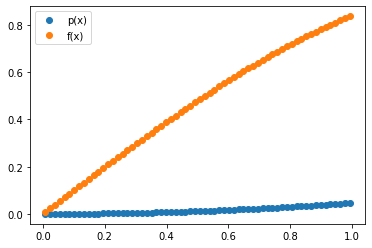

In [10]:
plt.plot(X, p_X, 'o')
plt.plot(X, f_X, 'o')
plt.legend(['p(x)', 'f(x)'])

## 3. Loading Probability

The $\mathcal{P}$ is implemented by an Abstract qlm gate called **CreatePG**. In order to create the gate only the numpy arrays with the probability should be provided.

The following function,**LoadProbabilityProgram**, creates a Quantum Program for loading a given probability numpy array on a quantum Circuit using the Abstract qlm gate called **CreatePG**

In [ ]:
from AuxiliarFunctions import TestBins, PostProcessResults
def LoadProbabilityProgram(p_X):
    """
    Creates a Quantum Program for loading an input numpy array with a probability distribution.
    Inputs:
        * p_X: np.array. Probability distribution of size m. Mandatory: m=2^n where n is the number
        qbits of the quantum circuit. 
    Outputs:
        * qprog: qlm program for loading input probability
    """
    #Qbits of the Quantum circuit depends on Probability length
    nqbits = TestBins(p_X, 'Probability')
    
    from qat.lang.AQASM import Program
    qprog = Program()
    qbits = qprog.qalloc(nqbits)
    #Creation of P_gate
    from dataloading_module import CreatePG
    P_gate = CreatePG(p_X)
    #Apply Abstract gate to the qbits
    qprog.apply(P_gate, qbits)
    return qprog


In [ ]:
circuit = LoadProbabilityProgram(p_X).to_circ()

In [ ]:
%qatdisplay circuit --depth 0 

Following cell simulates the circuit an postprocces result in order to test in probability was properly loaded. The results of the simulation is given to the **PostProcessResults** which create a pandas dataframe with the posible states and teh correspondings probabilities and amplitudes.

In [ ]:
job = circuit.to_job()
result = lineal_qpu.submit(job)
P_results = PostProcessResults(result.join())

In [ ]:
P_results.head()

In order to check if the operation was done properly we can compare the outpus probability of each state and the probabilities wanted to load:

In [ ]:
np.isclose(P_results['Probability'], p_X).all()

## 3. Loading Integral of a function

The $\mathcal{R}$ is implemented by an Abstract qlm gate called **CreateLoadFunctionGate**. For creating this gate a numpy array with the function evaluation shoul be provided. The length of this array should be: $m=2^n$ where n is an integer. The created gate is a $n+1$ gate where the last qbit codifies the integral of the function.

Following **LoadIntegralProgram** function creates a complete Quantum Program for loading Integral of discretized function $f(x)$ using the programed $\mathcal{R}$ gate. The size of the function array should be $2^n$ and the circuit will have $n+1$ qbit where the last one qbit will enconde the integral of the $f(x)$

In [ ]:
from AuxiliarFunctions import TestBins, PostProcessResults
def LoadIntegralProgram(f_X):
    """
    Creates a Quantum Circuit for loading the integral of the input numpy array with a function evaluation 
    Inputs:
        * f_X: np.array. Function evaluation of size m. Mandatory: m=2^n where n is the number
        qbits of the quantum circuit. 
    Outputs:
        * program: qlm program for loading integral of the input function
    """
    #Qbits of the Quantum circuit depends on Function array length
    nqbits = TestBins(f_X, 'Function')
    
    from qat.lang.AQASM import Program, H
    qprog = Program()
    #The additional qbit is where the integral will be encoded
    qbits = qprog.qalloc(nqbits+1)
    for i in range(nqbits):
        qprog.apply(H, qbits[i])
    #Creation of P_gate
    from dataloading_module import CreateLoadFunctionGate
    R_gate = CreateLoadFunctionGate(f_X)
    #Apply Abstract gate to the qbits
    qprog.apply(R_gate, qbits)
    return qprog

In [ ]:
circuit = LoadIntegralProgram(f_X).to_circ()

In [ ]:
%qatdisplay circuit --depth 0

In this case we are only interested in the last qbit of the circuit that encodes the desIred integral. Following cell simulates the circuit from *LoadIntegralProgram* and post process the results using *PostProcessResults* function which ouputs a pandas dataframe with the posible states (measurement of the last qbit) and the corresponding probability

In [ ]:
job = circuit.to_job(qubits = [n_qbits])
result = lineal_qpu.submit(job)
R_results = PostProcessResults(result.join())

In [ ]:
R_results.head()

In [ ]:
#Integral of f(x)
MeasurementIntegral = R_results['Probability'][1]*2**(n_qbits)

In [ ]:
np.isclose(MeasurementIntegral, sum(f_X))

## 4.Load Complete Data

If we have a variable $x$ that follows a probability distribution $p(x)$ we want to calculate the expectaction value of a function $f(x)$. So we want to compute:

$$E_{x\sim p}(f) = \int p(x)f(x)dx$$

Or in a discretized way:

$$E_{x\sim p}(f) = \sum_{x=0}^{2^n-1} p(x)f(x)dx$$

In order to do this first we need to load $p(x)$ and $f(x)$ in a quantum state:

$$|\Psi\rangle = \mathcal{R}(\mathcal{P} \otimes \mathbf{I})|0\rangle_{n}|0\rangle = \sum_{x=0}^{2^{n}-1}\sqrt{p(x)}|x\rangle_{n}\otimes (\sqrt{f(x)}|1\rangle +\sqrt{1-f(x)}|0\rangle)$$

Following functions use the $\mathcal{P}$ and $\mathcal{R}$ to do that

In [ ]:
from AuxiliarFunctions import TestBins, PostProcessResults
def LoadingData(p_X, f_X):
    """
    Load all the mandatory data to load in a quantum program the expected value 
    of a function f(x) over a x following a probability distribution p(x).
    Inputs:
        * p_X: np.array. Array of the discretized probability density
        * f_X: np.array. Array of the discretized funcion
    Outpus:
        * qprog: quantum program for loading the expected value of f(x) for x following a p(x) distribution
    """
    #Testing input
    nqbits_p = TestBins(p_X, 'Probability')
    nqbits_f = TestBins(f_X, 'Function')
    assert nqbits_p == nqbits_f, 'Arrays lenght are not equal!!'
    nqbits = nqbits_p
    
    #Creation of Gates
    from dataloading_module import CreatePG
    P_gate = CreatePG(p_X)    
    from dataloading_module import CreateLoadFunctionGate
    R_gate = CreateLoadFunctionGate(f_X)
    
    from qat.lang.AQASM import Program
    qprog = Program()
    qbits = qprog.qalloc(nqbits+1)
    #Load Probability
    qprog.apply(P_gate, qbits[:-1])
    #Load integral on the last qbit
    qprog.apply(R_gate, qbits)
    return qprog
    
    

In [ ]:
circuit = LoadingData(p_X, f_X).to_circ()

In [ ]:
%qatdisplay circuit --depth 0

The $E_{x\sim p}(f)$ is codified in the last qbit!

In [ ]:
job = circuit.to_job(qubits = [n_qbits])
result = lineal_qpu.submit(job)
PR_results = PostProcessResults(result.join())

In [ ]:
#Integral of f(x)
MeasurementIntegral = PR_results['Probability'][1]

In [ ]:
np.isclose(MeasurementIntegral, sum(p_X*f_X))

## 5. File Scripts

All the functions generated in this Notebook were stored in a python file, **dataloading_module_examples.py** in order to use it in an easy way:

In [ ]:
from dataloading_module_examples import LoadProbabilityProgram, LoadingData, LoadIntegralProgram

In [ ]:
def p(x):
    return x*x
def f(x):
    return np.sin(x)

In [ ]:
from AuxiliarFunctions import get_histogram, PostProcessResults
#number of Qbits for the circuit
n_qbits = 6
#The number of bins 
m_bins = 2**n_qbits
LowerLimit = 0.0
UpperLimit = 1.0 
X, p_X = get_histogram(p, LowerLimit, UpperLimit, m_bins)
f_X = f(X)

### 5.1 Probability Load

In [ ]:
circuitP = LoadProbabilityProgram(p_X).to_circ()
%qatdisplay circuitP

In [ ]:
jobP = circuitP.to_job()
resultP = lineal_qpu.submit(jobP)
P_results = PostProcessResults(resultP.join())
np.isclose(P_results['Probability'], p_X).all()

### 5.2 Integral Load

In [ ]:
circuitF = LoadIntegralProgram(f_X).to_circ()
%qatdisplay circuitF

In [ ]:
jobF = circuitF.to_job(qubits = [n_qbits])
resultF = lineal_qpu.submit(jobF)
F_results = PostProcessResults(resultF.join())
MeasurementIntegral = F_results['Probability'][1]*2**(n_qbits)
np.isclose(MeasurementIntegral, sum(f_X))

### 5.3 Complete Load

In [ ]:
circuitPF = LoadingData(p_X, f_X).to_circ()
%qatdisplay circuitPF

In [ ]:
jobPF = circuitPF.to_job(qubits = [n_qbits])
resultPF = lineal_qpu.submit(jobPF)
PF_results = PostProcessResults(resultPF.join())
MeasurementIntegral = PF_results['Probability'][1]
np.isclose(MeasurementIntegral, sum(p_X*f_X))